<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#10.1-GroupBy机制" data-toc-modified-id="10.1-GroupBy机制-1">10.1 GroupBy机制</a></span><ul class="toc-item"><li><span><a href="#10.1.1-对分组进行迭代" data-toc-modified-id="10.1.1-对分组进行迭代-1.1">10.1.1 对分组进行迭代</a></span></li><li><span><a href="#10.1.2-选取一列或列的子集" data-toc-modified-id="10.1.2-选取一列或列的子集-1.2">10.1.2 选取一列或列的子集</a></span></li><li><span><a href="#10.1.3-通过字典或Series进行分组" data-toc-modified-id="10.1.3-通过字典或Series进行分组-1.3">10.1.3 通过字典或Series进行分组</a></span></li><li><span><a href="#10.1.4-通过函数进行分组" data-toc-modified-id="10.1.4-通过函数进行分组-1.4">10.1.4 通过函数进行分组</a></span></li><li><span><a href="#10.1.5-根据索引级别分组" data-toc-modified-id="10.1.5-根据索引级别分组-1.5">10.1.5 根据索引级别分组</a></span></li></ul></li><li><span><a href="#10.2-数据聚合" data-toc-modified-id="10.2-数据聚合-2">10.2 数据聚合</a></span><ul class="toc-item"><li><span><a href="#10.2.1-面向列的多函数应用" data-toc-modified-id="10.2.1-面向列的多函数应用-2.1">10.2.1 面向列的多函数应用</a></span></li><li><span><a href="#10.2.2-以“没有行索引”的形式返回聚合数据" data-toc-modified-id="10.2.2-以“没有行索引”的形式返回聚合数据-2.2">10.2.2 以“没有行索引”的形式返回聚合数据</a></span></li></ul></li><li><span><a href="#10.3-apply：一般性的“拆分－应用－合并”" data-toc-modified-id="10.3-apply：一般性的“拆分－应用－合并”-3">10.3 apply：一般性的“拆分－应用－合并”</a></span><ul class="toc-item"><li><span><a href="#10.3.1-禁止分组键" data-toc-modified-id="10.3.1-禁止分组键-3.1">10.3.1 禁止分组键</a></span></li><li><span><a href="#10.3.2-分位数和桶分析" data-toc-modified-id="10.3.2-分位数和桶分析-3.2">10.3.2 分位数和桶分析</a></span></li><li><span><a href="#10.3.3-示例：用特定于分组的值填充缺失值" data-toc-modified-id="10.3.3-示例：用特定于分组的值填充缺失值-3.3">10.3.3 示例：用特定于分组的值填充缺失值</a></span></li><li><span><a href="#10.3.4-示例：随机采样和排列" data-toc-modified-id="10.3.4-示例：随机采样和排列-3.4">10.3.4 示例：随机采样和排列</a></span></li><li><span><a href="#10.3.5-示例：分组加权平均数和相关系数" data-toc-modified-id="10.3.5-示例：分组加权平均数和相关系数-3.5">10.3.5 示例：分组加权平均数和相关系数</a></span></li><li><span><a href="#10.3.6-示例：组级别的线性回归" data-toc-modified-id="10.3.6-示例：组级别的线性回归-3.6">10.3.6 示例：组级别的线性回归</a></span></li></ul></li><li><span><a href="#10.4-透视表和交叉表" data-toc-modified-id="10.4-透视表和交叉表-4">10.4 透视表和交叉表</a></span></li></ul></div>

# 第 10 章 数据聚合与分组运算

在本章中，你将会学到：

- 使用一个或多个键（形式可以是函数、数组或DataFrame列名）分割pandas对象。
- 计算分组的概述统计，比如数量、平均值或标准差，或是用户定义的函数。
- 应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。
- 计算透视表或交叉表。
- 执行分位数分析以及其它统计分组分析。

## 10.1 GroupBy机制

Hadley Wickham（许多热门R语言包的作者）创造了一个用于表示分组运算的术语"split-apply-combine"（拆分－应用－合并）。第一个阶段，pandas对象（无论是Series、DataFrame还是其他的）中的数据会根据你所提供的一个或多个键被拆分（split）为多组。拆分操作是在对象的特定轴上执行的。例如，DataFrame可以在其行（axis=0）或列（axis=1）上进行分组。然后，将一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执行结果会被合并（combine）到最终的结果对象中。结果对象的形式一般取决于数据上所执行的操作。图10-1大致说明了一个简单的分组聚合过程。

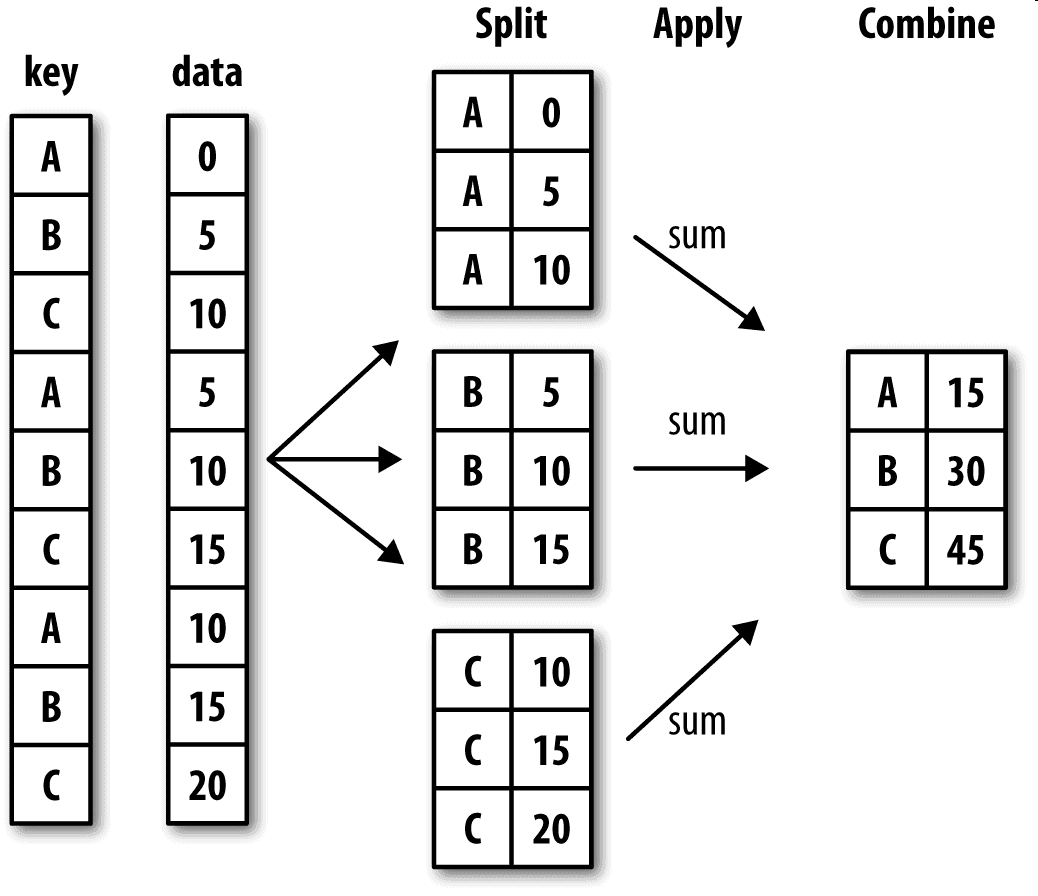

In [5]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

In [6]:
df = pd.DataFrame({"key1" : ["a", "a", None, "b", "b", "a", None],
                   "key2" : pd.Series([1, 2, 1, 2, 1, None, 1], dtype="Int64"),
                   "data1" : np.random.standard_normal(7),
                   "data2" : np.random.standard_normal(7)})
df

,key1,key2,data1,data2
0,a,1,-0.204708,0.281746
1,a,2,0.478943,0.769023
2,None,1,-0.519439,1.246435
3,b,2,-0.555730,1.007189
4,b,1,1.965781,-1.296221
5,a,<NA>,1.393406,0.274992
6,None,1,0.092908,0.228913


In [7]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [8]:
grouped.mean()

key1
a    0.555881
b    0.705025
Name: data1, dtype: float64

如果我们一次传入多个数组的列表，就会得到不同的结果：

In [9]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [10]:
means

key1  key2
a     1      -0.204708
      2       0.478943
b     1       1.965781
      2      -0.555730
Name: data1, dtype: float64

In [11]:
means.unstack()

key2,1,2
key1,,
a,-0.204708,0.478943
b,1.965781,-0.555730


以下是方文文的问题：

In [18]:
fww = pd.DataFrame(([25, 27, 28], [32, 43, 47]), index=['gene', 'trans'], columns=['novel', 'known', 'all'])
fww

,novel,known,all
gene,25,27,28
trans,32,43,47


In [30]:
fww.T.stack()

novel  gene     25
       trans    32
known  gene     27
       trans    43
all    gene     28
       trans    47
dtype: int64

In [31]:
fww.T.stack().to_csv('111.csv')

In [26]:
fww.stack().unstack(0)

,gene,trans
novel,25,32
known,27,43
all,28,47


In [27]:
fww.stack().unstack(0).stack()

novel  gene     25
       trans    32
known  gene     27
       trans    43
all    gene     28
       trans    47
dtype: int64

回到教程：

 在这个例子中，分组键均为Series。实际上，分组键可以是任何长度适当的数组：

In [34]:
states = np.array(["OH", "CA", "CA", "OH", "OH", "CA", "OH"])
years = [2005, 2005, 2006, 2005, 2006, 2005, 2006]
df["data1"].groupby([states, years]).mean()

CA  2005    0.936175
    2006   -0.519439
OH  2005   -0.380219
    2006    1.029344
Name: data1, dtype: float64

In [35]:
df

,key1,key2,data1,data2
0,a,1,-0.204708,0.281746
1,a,2,0.478943,0.769023
2,None,1,-0.519439,1.246435
3,b,2,-0.555730,1.007189
4,b,1,1.965781,-1.296221
5,a,<NA>,1.393406,0.274992
6,None,1,0.092908,0.228913


In [36]:
df["data1"]

0   -0.204708
1    0.478943
2   -0.519439
3   -0.555730
4    1.965781
5    1.393406
6    0.092908
Name: data1, dtype: float64

通常，分组信息就位于相同的要处理DataFrame中。这里，你还可以将列名（可以是字符串、数字或其他Python对象）用作分组键：

In [40]:
df.groupby('key1').mean()

,key2,data1,data2
key1,,,
a,1.5,0.555881,0.441920
b,1.5,0.705025,-0.144516


In [41]:
df.groupby('key2').mean()

,data1,data2
key2,,
1,0.333636,0.115218
2,-0.038393,0.888106


In [39]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    1    -0.204708  0.281746
     2     0.478943  0.769023
b    1     1.965781 -1.296221
     2    -0.555730  1.007189

无论你准备拿groupby做什么，都有可能会用到GroupBy的size方法，它可以返回一个含有分组大小的Series：

In [38]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     1       1
      2       1
b     1       1
      2       1
dtype: int64

### 10.1.1 对分组进行迭代

GroupBy对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）。看下面的例子：

In [42]:
for name, group in df.groupby("key1"):
    print(name)
    print(group)

a
  key1  key2     data1     data2
0    a     1 -0.204708  0.281746
1    a     2  0.478943  0.769023
5    a  <NA>  1.393406  0.274992
b
  key1  key2     data1     data2
3    b     2 -0.555730  1.007189
4    b     1  1.965781 -1.296221


### 10.1.2 选取一列或列的子集

### 10.1.3 通过字典或Series进行分组

### 10.1.4 通过函数进行分组

### 10.1.5 根据索引级别分组

## 10.2 数据聚合

### 10.2.1 面向列的多函数应用

### 10.2.2 以“没有行索引”的形式返回聚合数据

## 10.3 apply：一般性的“拆分－应用－合并”

最通用的GroupBy方法是apply，本节剩余部分将重点讲解它。如图10-2所示，apply会将待处理的对象拆分成多个片段，然后对各片段调用传入的函数，最后尝试将各片段组合到一起。

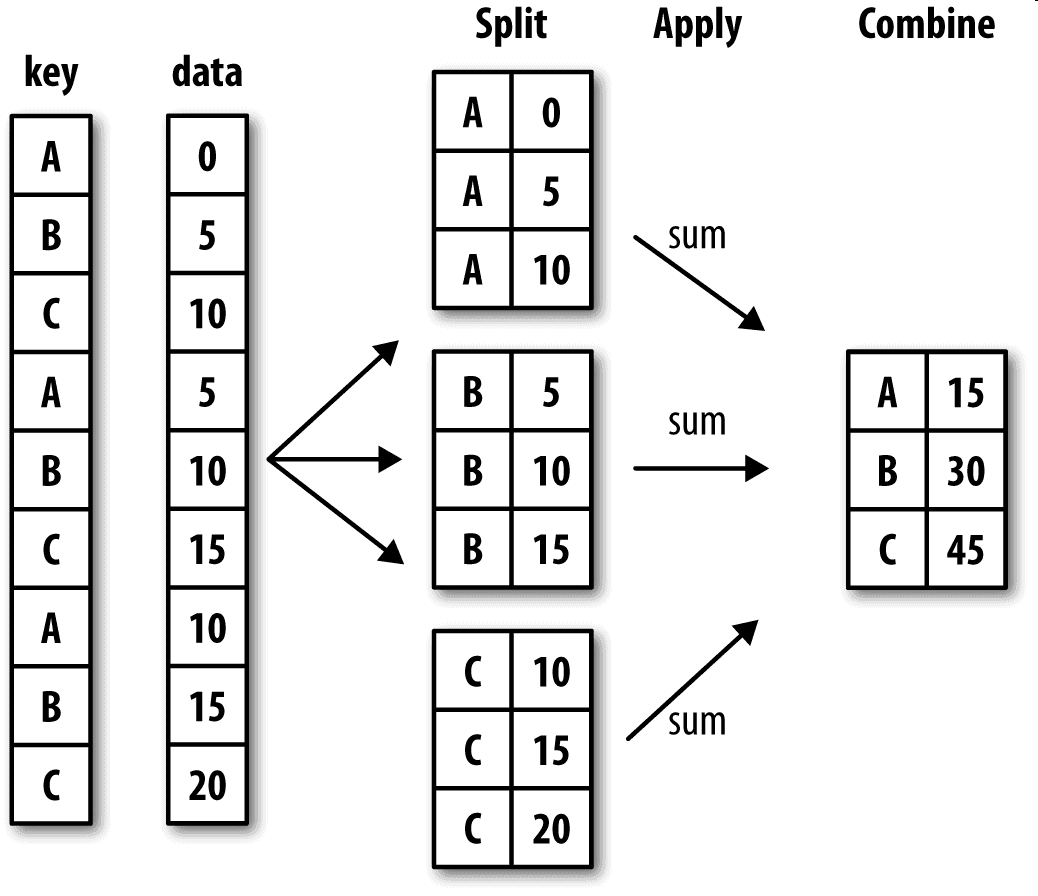

In [47]:
tips = pd.read_csv('tips.csv')

In [48]:
tips

,total_bill,tip,smoker,day,time,size
0,16.99,1.01,No,Sun,Dinner,2
1,10.34,1.66,No,Sun,Dinner,3
2,21.01,3.50,No,Sun,Dinner,3
3,23.68,3.31,No,Sun,Dinner,2
4,24.59,3.61,No,Sun,Dinner,4
...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3
240,27.18,2.00,Yes,Sat,Dinner,2
241,22.67,2.00,Yes,Sat,Dinner,2
242,17.82,1.75,No,Sat,Dinner,2


In [51]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [52]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204


In [49]:
def top(df, n=5, column='tip_pct'):
        return df.sort_values(by=column)[-n:]

In [53]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


现在，如果对smoker分组并用该函数调用apply，就会得到：

In [54]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

这里发生了什么？top函数在DataFrame的各个片段上调用，然后结果由pandas.concat组装到一起，并以分组名称进行了标记。于是，最终结果就有了一个层次化索引，其内层索引值来自原DataFrame。

如果传给apply的函数能够接受其他参数或关键字，则可以将这些内容放在函数名后面一并传入：

In [55]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

> Note：除这些基本用法之外，能否充分发挥apply的威力很大程度上取决于你的创造力。传入的那个函数能做什么全由你说了算，它只需返回一个pandas对象或标量值即可。本章后续部分的示例主要用于讲解如何利用groupby解决各种各样的问题。

In [56]:
tips.groupby('smoker')['tip_pct']

### 10.3.1 禁止分组键

从上面的例子中可以看出，分组键会跟原始对象的索引共同构成结果对象中的层次化索引。将group_keys=False传入groupby即可禁止该效果：

In [57]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [58]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

### 10.3.2 分位数和桶分析

### 10.3.3 示例：用特定于分组的值填充缺失值

对于缺失数据的清理工作，有时你会用dropna将其替换掉，而有时则可能会希望用一个固定值或由数据集本身所衍生出来的值去填充NA值。这时就得使用fillna这个工具了。在下面这个例子中，我用平均值去填充NA值：

In [59]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.886429
2         NaN
3   -0.371843
4         NaN
5   -0.438570
dtype: float64

In [60]:
s.fillna(s.mean())

0    0.025339
1    0.886429
2    0.025339
3   -0.371843
4    0.025339
5   -0.438570
dtype: float64

假设你需要对不同的分组填充不同的值。一种方法是将数据分组，并使用apply和一个能够对各数据块调用fillna的函数即可。下面是一些有关美国几个州的示例数据，这些州又被分为东部和西部：

In [61]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
           'Oregon', 'Nevada', 'California', 'Idaho']

In [64]:
group_key = ['East'] * 4 + ['West'] * 4
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [63]:
data = pd.Series(np.random.randn(8), index=states)
data

Ohio         -0.539741
New York      0.476985
Vermont       3.248944
Florida      -1.021228
Oregon       -0.577087
Nevada        0.124121
California    0.302614
Idaho         0.523772
dtype: float64

In [65]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -0.539741
New York      0.476985
Vermont            NaN
Florida      -1.021228
Oregon       -0.577087
Nevada             NaN
California    0.302614
Idaho              NaN
dtype: float64

In [67]:
data.groupby(group_key).mean()

East   -0.361328
West   -0.137237
dtype: float64

我们可以用分组平均值去填充NA值:

In [68]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.539741
New York      0.476985
Vermont      -0.361328
Florida      -1.021228
Oregon       -0.577087
Nevada       -0.137237
California    0.302614
Idaho        -0.137237
dtype: float64

另外，也可以在代码中预定义各组的填充值。由于分组具有一个name属性，所以我们可以拿来用一下：

In [69]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio         -0.539741
New York      0.476985
Vermont       0.500000
Florida      -1.021228
Oregon       -0.577087
Nevada       -1.000000
California    0.302614
Idaho        -1.000000
dtype: float64

### 10.3.4 示例：随机采样和排列

### 10.3.5 示例：分组加权平均数和相关系数

### 10.3.6 示例：组级别的线性回归

## 10.4 透视表和交叉表